# Imports

In [1]:
import os
from sys import path
path.append('../')
import cv2

import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras import models, layers
from src.dataset import PneumoniaDetectionChallenge

# Dataset loading for training

In [2]:
DATASET_PATH = '../datasets/rsna-pneumonia-detection-challenge/'

In [6]:
pdc = PneumoniaDetectionChallenge(DATASET_PATH)
x_train, y_train, _ = pdc.load_train_data()

In [4]:
x_train = x_train / 255.0
x_train = x_train.reshape(-1, 256, 256, 1)

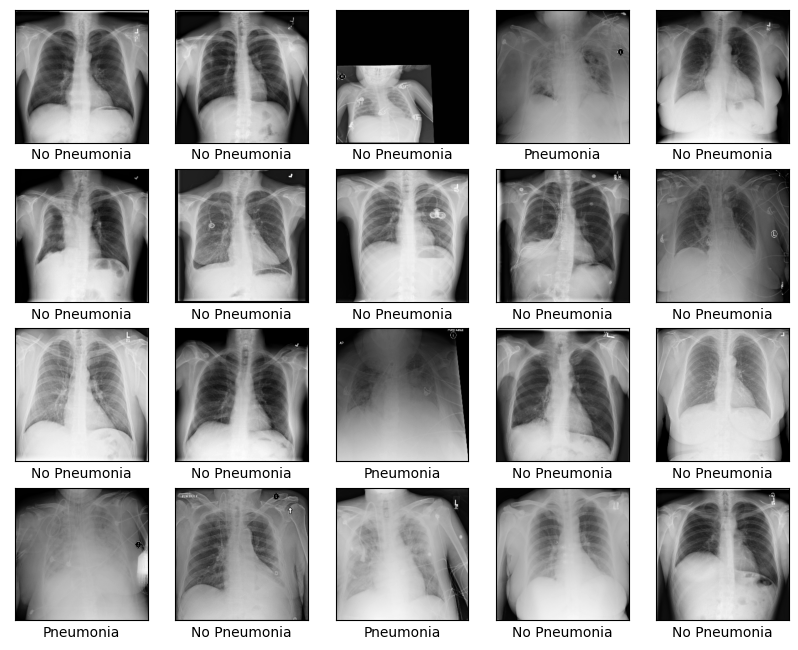

In [5]:
class_names = ['No Pneumonia', 'Pneumonia']

plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(5 ,5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap='gray')
    plt.xlabel(class_names[y_train[i]])
plt.show()

# Mdel definition

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, activation='relu', kernel_size=3, padding='same', input_shape=(256, 256, 1)))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=64, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=128, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=128, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=128, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       1

In [7]:
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       1

In [8]:
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=["binary_accuracy"])

# Model training

In [9]:
history = model.fit(x_train, y_train, epochs=15)

Epoch 1/15
626/626 [==============================] - 31s 41ms/step - loss: 0.4919 - binary_accuracy: 0.7880
Epoch 2/15
626/626 [==============================] - 25s 39ms/step - loss: 0.4308 - binary_accuracy: 0.7985
Epoch 3/15
626/626 [==============================] - 25s 39ms/step - loss: 0.4228 - binary_accuracy: 0.8089
Epoch 4/15
626/626 [==============================] - 24s 39ms/step - loss: 0.4179 - binary_accuracy: 0.8119
Epoch 5/15
626/626 [==============================] - 24s 39ms/step - loss: 0.4125 - binary_accuracy: 0.8145
Epoch 6/15
626/626 [==============================] - 25s 39ms/step - loss: 0.4029 - binary_accuracy: 0.8155
Epoch 7/15
626/626 [==============================] - 24s 39ms/step - loss: 0.4045 - binary_accuracy: 0.8153
Epoch 8/15
626/626 [==============================] - 24s 39ms/step - loss: 0.3928 - binary_accuracy: 0.8231
Epoch 9/15
626/626 [==============================] - 24s 39ms/step - loss: 0.3852 - binary_accuracy: 0.8281
Epoch 10/15
626/626

In [10]:
del x_train
del y_train

# Evaluating the model

In [11]:
x_test, y_test, patients_id = pdc.load_test_data()
x_test = x_test / 255.0
x_test = x_test.reshape(-1, 256, 256, 1)

In [12]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

209/209 [==============================] - 3s 16ms/step - loss: 0.4707 - binary_accuracy: 0.8024


In [13]:
predictions = model.predict(x_test)
predictions_rounded = np.round(predictions).astype(int)

In [14]:
test_labels_df = pdc.get_test_labels_df()

for patient_id, prediction in zip(patients_id, predictions_rounded):
    test_labels_df.loc[test_labels_df['patientId'] == patient_id, 'Prediction'] = prediction
test_labels_df.Prediction = test_labels_df.Prediction.astype(int)

In [15]:
hits = test_labels_df[test_labels_df['Target'] == test_labels_df['Prediction']].count()[1]
errors = test_labels_df[test_labels_df['Target'] != test_labels_df['Prediction']].count()[1]

In [16]:
print('General:')
print(' - Total:: ' + str(hits + errors))
print(' - Hits:: ' + str(hits))
print(' - Errors: ' + str(errors))
print(' - Hits ratio: ' + str(hits / (hits + errors)))

General:
 - Total:: 6671
 - Hits:: 5353
 - Errors: 1318
 - Hits ratio: 0.8024284215260081


In [17]:
hits = test_labels_df[(test_labels_df['Target'] == 0) & (test_labels_df['Target'] == test_labels_df['Prediction'])].count()[1]
errors = test_labels_df[(test_labels_df['Target'] == 0) & (test_labels_df['Target'] != test_labels_df['Prediction'])].count()[1]

In [18]:
print('No Pneumonia:')
print(' - Total: ' + str(hits + errors))
print(' - Hits: ' + str(hits))
print(' - Errors: ' + str(errors))
print(' - Hits ratio: ' + str(hits / (hits + errors)))

No Pneumonia:
 - Total: 5114
 - Hits: 4732
 - Errors: 382
 - Hits ratio: 0.9253030895580758


In [19]:
hits = test_labels_df[(test_labels_df['Target'] == 1) & (test_labels_df['Target'] == test_labels_df['Prediction'])].count()[1]
errors = test_labels_df[(test_labels_df['Target'] == 1) & (test_labels_df['Target'] != test_labels_df['Prediction'])].count()[1]

In [20]:
print('Pneumonia:')
print(' - Total: ' + str(hits + errors))
print(' - Hits: ' + str(hits))
print(' - Errors: ' + str(errors))
print(' - Hits ratio: ' + str(hits / (hits + errors)))

Pneumonia:
 - Total: 1557
 - Hits: 621
 - Errors: 936
 - Hits ratio: 0.3988439306358382
